# Deep Learning

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler

torch.set_printoptions(precision=5, sci_mode=False, linewidth=120)

data=pd.read_csv('./data/polar.csv')
x=data.iloc[:,0:-1]
y=data.iloc[:,-1]

X_train, X_test, y_train, y_test=train_test_split(x, y, random_state= 3, test_size=0.15, shuffle=True)
sc=MinMaxScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)

In [2]:
model = nn.Sequential(nn.Linear(12, 6), nn.ReLU(), nn.Linear(6, 3), nn.ReLU(), nn.Linear(3, 1))
model

Sequential(
  (0): Linear(in_features=12, out_features=6, bias=True)
  (1): ReLU()
  (2): Linear(in_features=6, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=1, bias=True)
)

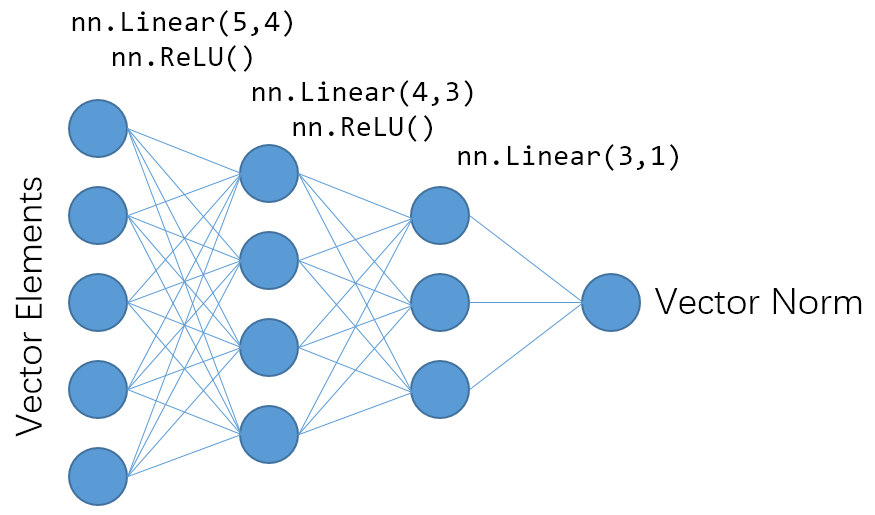
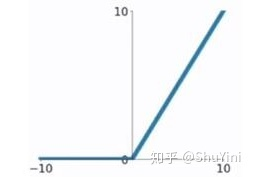

In [3]:
X_train_std = torch.tensor(X_train_std.astype(np.float32))
y_train = np.array([y_train.to_numpy()])
y_train = y_train.T 
y_train = torch.tensor(y_train.astype(np.float32))


optimizer = torch.optim.Adam(model.parameters(), .5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=5, min_lr=1e-5)

def train_with_scheduler(model, X, t, scheduler):
    y = model(X)
    loss = nn.L1Loss()(y, t)
    scheduler.optimizer.zero_grad()
    loss.backward()
    scheduler.optimizer.step()
    scheduler.step(loss)
    return loss


for epoch in range(0, 1001):
    loss = train_with_scheduler(model, X_train_std, y_train, scheduler)
    if epoch % 200 == 0:
        print("Loss in epoch {:4d}: {:10.6f}".format(epoch, loss))


X_test_std = torch.tensor(X_test_std.astype(np.float32))

y_train_pre = model(X_train_std)
y_test_pre = model(X_test_std)

print(y_train)
print(y_train_pre.detach().numpy().T)

mse=mean_squared_error(y_test,y_test_pre.detach())
mae=mean_absolute_error(y_test,y_test_pre.detach())
r2=r2_score(y_test,y_test_pre.detach())
               
print('MSE:',mse)
print('MAE',mae)
print('R2',r2)

Loss in epoch    0: 277.704926
Loss in epoch  200:   5.000969
Loss in epoch  400:   4.686530
Loss in epoch  600:   4.549878
Loss in epoch  800:   4.478054
Loss in epoch 1000:   4.433669
tensor([[283.32999],
        [345.39999],
        [319.14999],
        ...,
        [244.94000],
        [263.00000],
        [391.67001]])
[[280.65146 336.89105 315.5798  ... 245.69583 263.54297 386.2277 ]]
MSE: 34.620448673551635
MAE 4.576792808889116
R2 0.9834452196238045


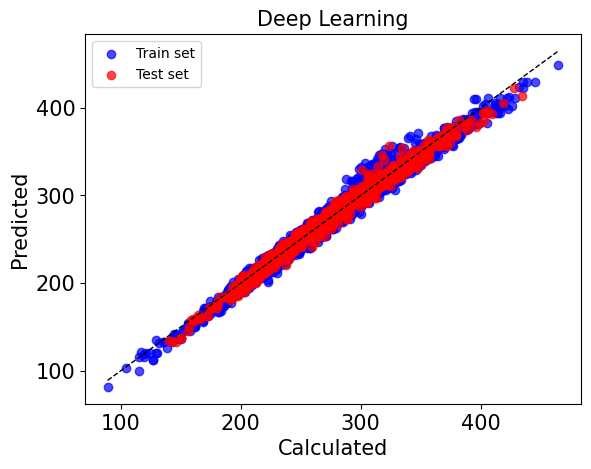

In [4]:
#plot
plt.scatter(y_train, y_train_pre.detach().numpy().T,label='Train set', color='b',marker='o',alpha=0.7)
plt.scatter(y_test, y_test_pre.detach().numpy().T,label='Test set', color='r',marker='o', alpha=0.7)
plt.legend() #显示图例

plt.plot([y.min(),y.max()],
         [y.min(),y.max()],
         '--k',linewidth=1)
plt.tick_params(labelsize=15)
plt.xlabel('Calculated',size=15)
plt.ylabel('Predicted',size=15)
plt.title('Deep Learning',size=15)
plt.savefig('out1.png',dpi=300)
plt.show()